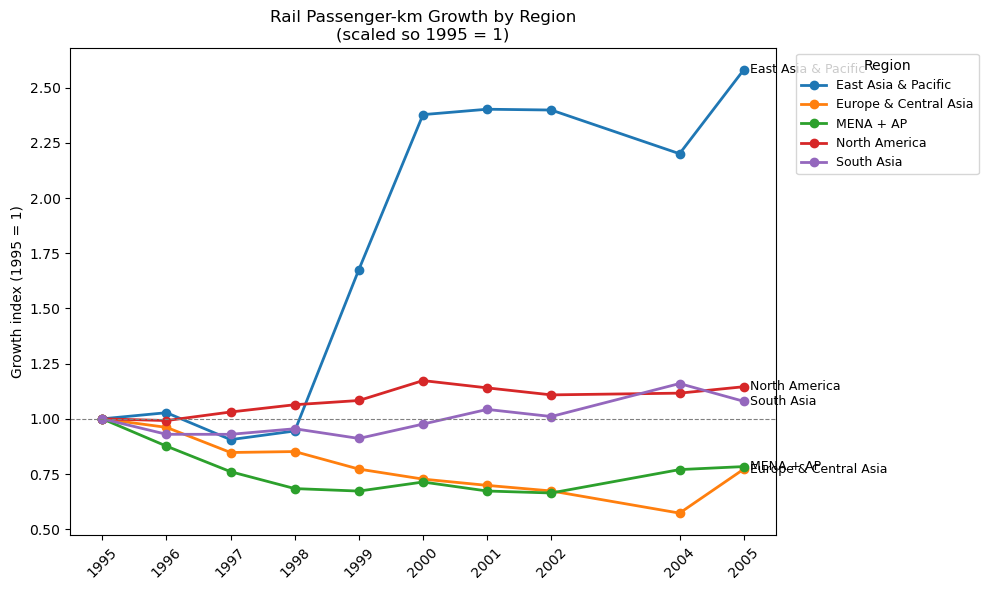

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

# -----------------------------
# 1. Load data
# -----------------------------
df = pd.read_csv("railways-passengers-carried-passenger-km.csv")
pkm_col = "Railways, passengers carried (million passenger-km)"

regions = [
    "East Asia and Pacific (WB)",
    "Europe and Central Asia (WB)",
    "Middle East, North Africa, Afghanistan and Pakistan (WB)",
    "North America (WB)",
    "South Asia (WB)",
]

short_name = {
    "East Asia and Pacific (WB)": "East Asia & Pacific",
    "Europe and Central Asia (WB)": "Europe & Central Asia",
    "Middle East, North Africa, Afghanistan and Pakistan (WB)": "MENA + AP",
    "North America (WB)": "North America",
    "South Asia (WB)": "South Asia",
}

region_df = df[df["Entity"].isin(regions)].copy()

# -----------------------------
# 2. Find years common to ALL regions
# -----------------------------
year_sets = {
    r: set(region_df[region_df["Entity"] == r]["Year"])
    for r in regions
}

common_years = sorted(list(reduce(set.intersection, year_sets.values())))
# If you want, you can limit to a more recent range here

# -----------------------------
# 3. Build pivot table and growth index
# -----------------------------
common_df = region_df[region_df["Year"].isin(common_years)]

pivot = common_df.pivot(index="Year", columns="Entity", values=pkm_col)
pivot = pivot[regions]  # keep consistent order

# Normalize so first common year = 1 for each region
base_year = common_years[0]
base_values = pivot.loc[base_year]
growth_index = pivot.div(base_values, axis=1)

# -----------------------------
# 4. Plot “multi-year slopegraph”
# -----------------------------
plt.figure(figsize=(10, 6))
ax = plt.gca()

for region in regions:
    ax.plot(
        common_years,
        growth_index[region],
        marker="o",
        linewidth=2,
        label=short_name[region],
    )
    # Label only the last point for each line
    last_year = common_years[-1]
    last_val = growth_index.loc[last_year, region]
    ax.text(
        last_year + 0.1,
        last_val,
        short_name[region],
        va="center",
        fontsize=9,
    )

# baseline (no growth)
ax.axhline(1.0, color="grey", linestyle="--", linewidth=0.8)

ax.set_xticks(common_years)
ax.set_xticklabels(common_years, rotation=45)
ax.set_ylabel(f"Growth index ({base_year} = 1)")
ax.set_title(
    "Rail Passenger-km Growth by Region\n"
    f"(scaled so {base_year} = 1)"
)

# keep legend for color reference, but move it out of the way
ax.legend(title="Region", bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=9)

plt.tight_layout()
plt.show()
